# Scaling Laws Analysis

This notebook visualizes the relationship between:
- **FactorVAE score** and **Reconstruction quality (reco)** 
- vs $\beta_S$ (bs1, bs100, bs500) and $\beta_T$ (bt1, bt100)

**Goal**: Determine if FactorVAE score is ~invariant to $\dim_S$ while reco increases, or if FactorVAE increases with $\beta_S$.

In [177]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from pathlib import Path

metrics_path = Path("../../metrics_final_0.json")
with open(metrics_path, "r") as f:
    metrics = json.load(f)

print("Available latent dimensions:", list(metrics.keys()))
print(
    "Available datasets:",
    list(metrics["126"]["shapes"].keys()) if "126" in metrics else "N/A",
)

Available latent dimensions: ['2', '8', '126']
Available datasets: ['bt1', 'bt100']


## config params

In [178]:
DIM_S = "126"
DATASET = "shapes"
MODE = "n-1"  # ["all", "n-1"]
BETA_T_VALUES = ["bt1", "bt100"]
BETA_S_VALUES = ["bs1", "bs100", "bs500"]
BETA_S_NUMERIC = [1, 100, 500]
METRICS_TO_PLOT = ["score", "d", "c", "i", "reco"]

COMPARE_DATASETS = ["shapes", "dsprites", "mpi3d", "cars3d", "celeba"]
# COMPARE_DATASETS = ["mpi3d", "cars3d", "celeba"]
# COMPARE_DATASETS = ["shapes", "dsprites"]
DIM_S_VALUES = sorted(metrics.keys(), key=lambda x: int(x))
DATASETS_TO_PLOT = COMPARE_DATASETS if "COMPARE_DATASETS" in globals() else [DATASET]

BETA_T_MARKERS = {"bt1": "o", "bt100": "s"}
BETA_T_LINESTYLES = {"bt1": "-", "bt100": "--"}

dataset_colors = {
    "shapes": "tab:blue",
    "dsprites": "tab:orange",
    "mpi3d": "tab:green",
    "cars3d": "tab:red",
    "celeba": "tab:purple",
}

print("config:")
print(f"  dim S: {DIM_S}")
print(f"  dataset: {DATASET}")
print(f"  mode: {MODE}")
print(f"  beta_T values: {BETA_T_VALUES}")
print(f"  beta_S values: {BETA_S_VALUES}")

config:
  dim S: 126
  dataset: shapes
  mode: n-1
  beta_T values: ['bt1', 'bt100']
  beta_S values: ['bs1', 'bs100', 'bs500']


## extract from .json

In [220]:
def create_df_from_json(dim_s_list, mode, metrics_list):
    def _normalize_value(v):
        if v is None or v == -1:
            return None
        if isinstance(v, (list, tuple)):
            return v[0] if len(v) > 0 else None
        return v

    rows = []
    for dataset in DATASETS_TO_PLOT:
        for bt in BETA_T_VALUES:
            for dim_s in dim_s_list:
                for bs in BETA_S_VALUES:
                    try:
                        entry = metrics[dim_s][dataset][bt][bs][mode]
                    except KeyError:
                        continue

                    row = {
                        "dataset": dataset,
                        "beta_t": bt,
                        "beta_s": bs,
                        "dim_s": int(dim_s),
                    }

                    any_metric = False
                    for m in metrics_list:
                        val = _normalize_value(entry.get(m))
                        if isinstance(val, (int, float)) and np.isfinite(val):
                            row[m] = float(val)
                            any_metric = True
                        else:
                            row[m] = np.nan

                    if any_metric:
                        rows.append(row)

    return pd.DataFrame(rows)

In [221]:
METRICS_TO_PLOT = ["score", "reco"]

df_reco = create_df_from_json(DIM_S_VALUES, MODE, METRICS_TO_PLOT)
df_reco

,dataset,beta_t,beta_s,dim_s,score,reco
0,shapes,bt1,bs1,2,0.99998,0.000061
1,shapes,bt1,bs100,2,0.83540,0.000080
2,shapes,bt1,bs500,2,0.83592,0.000081
3,shapes,bt1,bs1,8,1.00000,0.000073
4,shapes,bt1,bs100,8,1.00000,0.000125
...,...,...,...,...,...,...
85,celeba,bt100,bs100,8,0.50272,0.013787
86,celeba,bt100,bs500,8,0.47528,0.015484
87,celeba,bt100,bs1,126,0.53958,0.003523
88,celeba,bt100,bs100,126,0.53118,0.009436


## FactorVAE Score vs Reco

In [206]:
# usetex
plt.rcParams["text.usetex"] = True

# Axis limits (set to None to auto-scale)
X_LIM = None
Y_LIM = 0.6

# Plot style toggles
SHOW_STD = True
SHOW_LABELS = False

# Filter by beta_s (set to None to include all)
BETA_S_FILTER = "bs100"  # e.g., "bs100"

# Label style
LABEL_FONTSIZE = 14
LABEL_BBOX = dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7)


In [207]:
def plot_score_vs_reco(df, dim_s_list, mode):
    fig, ax = plt.subplots(figsize=(11, 6.5))
    ax.set_facecolor("#fafafa")

    x_col = "reco_mean" if "reco_mean" in df.columns else "reco"
    y_col = "score_mean" if "score_mean" in df.columns else "score"
    xerr_col = "reco_std" if "reco_std" in df.columns else None
    yerr_col = "score_std" if "score_std" in df.columns else None
    use_std = SHOW_STD and (xerr_col is not None) and (yerr_col is not None)

    for dataset in DATASETS_TO_PLOT:
        color = dataset_colors.get(dataset, None)
        for bt in BETA_T_VALUES:
            df_subset = df[(df["dataset"] == dataset) & (df["beta_t"] == bt)]
            if df_subset.empty:
                continue

            if "beta_s" in df_subset.columns:
                if BETA_S_FILTER is None:
                    bs_values = df_subset["beta_s"].dropna().unique().tolist()
                else:
                    bs_values = [BETA_S_FILTER]
            else:
                bs_values = [None]

            for bs in bs_values:
                df_run = (
                    df_subset if bs is None else df_subset[df_subset["beta_s"] == bs]
                )
                if df_run.empty:
                    continue
                df_run = df_run.sort_values("dim_s")
                df_run = df_run.dropna(subset=[x_col, y_col])
                if df_run.empty:
                    continue

                marker = BETA_T_MARKERS.get(bt, "o")
                open_marker = bt == "bt100"

                if use_std:
                    ax.errorbar(
                        df_run[x_col],
                        df_run[y_col],
                        xerr=df_run[xerr_col],
                        yerr=df_run[yerr_col],
                        fmt=marker,
                        color=color,
                        ecolor=color,
                        elinewidth=1.0,
                        capsize=2.5,
                        markersize=7,
                        mfc="none" if open_marker else color,
                        mec=color if open_marker else "black",
                        linestyle="None",
                        zorder=3,
                    )
                else:
                    ax.scatter(
                        df_run[x_col],
                        df_run[y_col],
                        marker=marker,
                        s=55,
                        facecolors="none" if open_marker else color,
                        edgecolors=color if open_marker else "black",
                        linewidths=0.8,
                        zorder=3,
                    )

                # Link points from the same run across dim_s
                ax.plot(
                    df_run[x_col],
                    df_run[y_col],
                    color=color,
                    linestyle=BETA_T_LINESTYLES.get(bt, "-"),
                    linewidth=1.2,
                    alpha=0.6,
                    zorder=2,
                )

                if SHOW_LABELS:
                    for _, row in df_run.iterrows():
                        ax.annotate(
                            f"S={int(row['dim_s'])}",
                            (row[x_col], row[y_col]),
                            xytext=(0, 6),
                            textcoords="offset points",
                            fontsize=LABEL_FONTSIZE,
                            color=color,
                            ha="center",
                            bbox=LABEL_BBOX,
                        )

    if x_col.endswith("_mean"):
        ax.set_xlabel("Reconstruction (mean $\pm$ std over $\\dim_S$)", fontsize=14)
        ax.set_ylabel("FactorVAE Score (mean $\pm$ std over $\\dim_S$)", fontsize=14)
    else:
        ax.set_xlabel("Reconstruction (per $\\dim_S$)", fontsize=14)
        ax.set_ylabel("FactorVAE Score (per $\\dim_S$)", fontsize=14)
    ax.set_title(
        f"FactorVAE Score vs Reconstruction",
        fontsize=14,
    )

    ax.set_xlim(left=0.0)
    # ax.invert_xaxis()
    # ax.set_ylim(bottom=0.85)
    ax.grid(True, alpha=0.3)

    handles_datasets = [
        Line2D(
            [0],
            [0],
            color=dataset_colors.get(d, "gray"),
            marker="o",
            linestyle="-",
            label=d,
        )
        for d in DATASETS_TO_PLOT
    ]
    handles_bt = [
        Line2D(
            [0],
            [0],
            color="black",
            marker=BETA_T_MARKERS.get(bt, "o"),
            linestyle="None",
            label=f"$\\beta_T$ = {bt.replace('bt', '')}",
        )
        for bt in BETA_T_VALUES
    ]
    legend1 = ax.legend(
        handles=handles_datasets, title="Dataset", fontsize=10, loc="best"
    )
    ax.add_artist(legend1)
    ax.legend(handles=handles_bt, title=r"$\beta_T$", fontsize=10, loc="lower right")

    plt.tight_layout()
    plt.show()

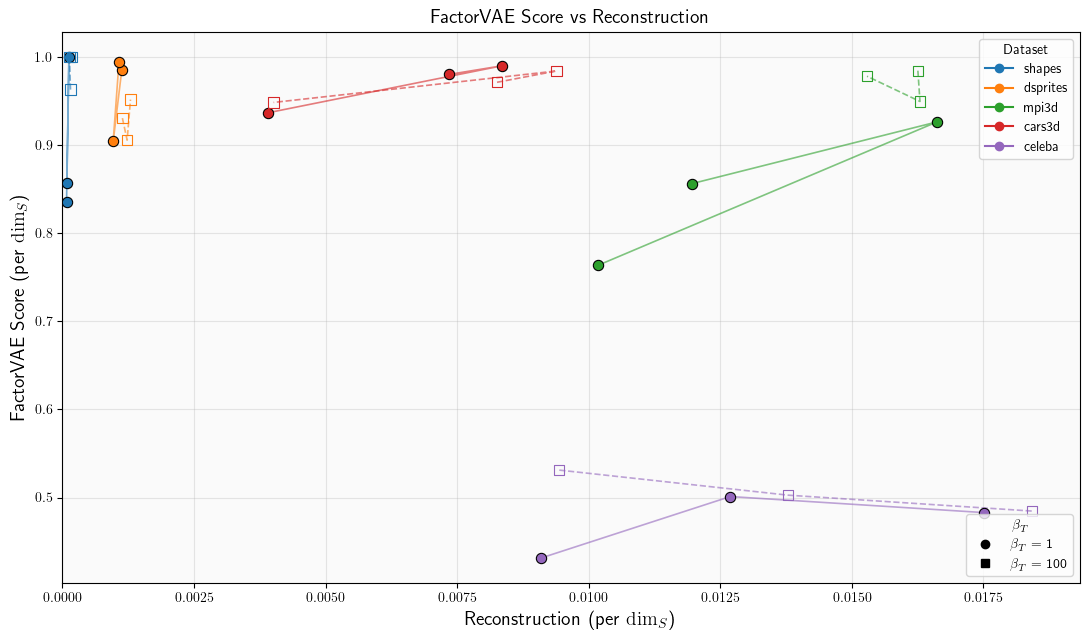

In [208]:
plot_score_vs_reco(df_reco, DIM_S_VALUES, MODE)

## FactorVAE Score vs dim_S

False


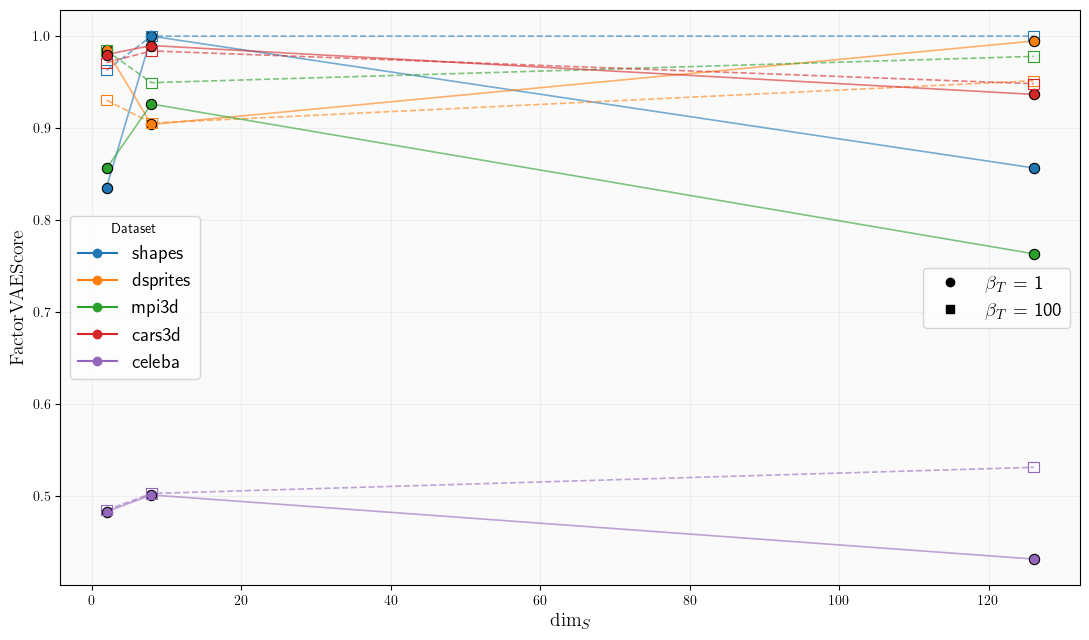

In [222]:
def plot_score_vs_dim_s(df, dim_s_list, mode):
    fig, ax = plt.subplots(figsize=(11, 6.5))
    ax.set_facecolor("#fafafa")

    y_col = "score_mean" if "score_mean" in df.columns else "score"
    yerr_col = "score_std" if "score_std" in df.columns else None
    use_std = SHOW_STD and (yerr_col is not None)
    print(use_std)

    for dataset in DATASETS_TO_PLOT:
        color = dataset_colors.get(dataset, None)
        for bt in BETA_T_VALUES:
            df_subset = df[(df["dataset"] == dataset) & (df["beta_t"] == bt)]
            if df_subset.empty:
                continue

            if "beta_s" in df_subset.columns:
                if BETA_S_FILTER is None:
                    bs_values = df_subset["beta_s"].dropna().unique().tolist()
                else:
                    bs_values = [BETA_S_FILTER]
            else:
                bs_values = [None]

            for bs in bs_values:
                df_run = (
                    df_subset if bs is None else df_subset[df_subset["beta_s"] == bs]
                )
                if df_run.empty:
                    continue
                df_run = df_run.sort_values("dim_s")
                df_run = df_run.dropna(subset=["dim_s", y_col])
                if df_run.empty:
                    continue

                marker = BETA_T_MARKERS.get(bt, "o")
                open_marker = bt == "bt100"

                if use_std:
                    ax.errorbar(
                        df_run["dim_s"],
                        df_run[y_col],
                        yerr=df_run[yerr_col],
                        fmt=marker,
                        color=color,
                        ecolor=color,
                        elinewidth=1.0,
                        capsize=2.5,
                        markersize=7,
                        mfc="none" if open_marker else color,
                        mec=color if open_marker else "black",
                        linestyle="None",
                        zorder=3,
                    )
                else:
                    ax.scatter(
                        df_run["dim_s"],
                        df_run[y_col],
                        marker=marker,
                        s=55,
                        facecolors="none" if open_marker else color,
                        edgecolors=color if open_marker else "black",
                        linewidths=0.8,
                        zorder=3,
                    )

                # Link points from the same run across dim_s
                ax.plot(
                    df_run["dim_s"],
                    df_run[y_col],
                    color=color,
                    linestyle=BETA_T_LINESTYLES.get(bt, "-"),
                    linewidth=1.2,
                    alpha=0.6,
                    zorder=2,
                )

                if SHOW_LABELS:
                    for _, row in df_run.iterrows():
                        ax.annotate(
                            f"S={int(row['dim_s'])}",
                            (row["dim_s"], row[y_col]),
                            xytext=(0, 6),
                            textcoords="offset points",
                            fontsize=LABEL_FONTSIZE,
                            color=color,
                            ha="center",
                            bbox=LABEL_BBOX,
                        )

    if y_col.endswith("_mean"):
        ax.set_ylabel("FactorVAE Score (mean $\pm$ std over $\\dim_S$)", fontsize=14)
    else:
        ax.set_ylabel(r"$\mathrm{FactorVAE Score}$", fontsize=14)
    ax.set_xlabel(r"$\mathrm{dim}_S$", fontsize=14)
    ax.set_title("", fontsize=14)

    ax.grid(True, alpha=0.3)

    handles_datasets = [
        Line2D(
            [0],
            [0],
            color=dataset_colors.get(d, "gray"),
            marker="o",
            linestyle="-",
            label=d,
        )
        for d in DATASETS_TO_PLOT
    ]
    handles_bt = [
        Line2D(
            [0],
            [0],
            color="black",
            marker=BETA_T_MARKERS.get(bt, "o"),
            linestyle="None",
            label=f"$\\beta_T$ = {bt.replace('bt', '')}",
        )
        for bt in BETA_T_VALUES
    ]
    legend1 = ax.legend(
        handles=handles_datasets, title="Dataset", fontsize=14, loc="best"
    )
    ax.add_artist(legend1)
    ax.legend(handles=handles_bt, fontsize=14, loc="center right")

    ax.grid(True, alpha=0.15)
    plt.tight_layout()
    plt.savefig(f"scaling_laws.pdf", dpi=300)
    plt.show()


plot_score_vs_dim_s(df_reco, DIM_S_VALUES, MODE)
